In [9]:
#Do all imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from varname import nameof
from os import listdir
from astropy.io import ascii

import header_maker as hm
import sys

#Make sure we print a bit cleaner
np.set_printoptions(precision = 2 )
please_plot = True
please_print = True

In [10]:
#These are important inputs. They set what part of the envelope get mixed into the core (core_percent)
save = True
do_dessart_ni = True
contrast_factor = 30
requested_models = ['he8.00.1p-1d'] #Write as 'hex.xx.1p-1d'
version_name = 'v1p0' #Write as 'vxpx'
git_folder_loc = '/home/masterofalorgia/'

In [11]:
#The cell below contains helper function for reading in the woosley data. They require no changes.
def name_to_number(string): #Function to translate a header name to the corresponding column number
    '''Convert the string to the corresponding
    column index for the woosley data'''
    
    try:
        location = np.where(header_array == string)[0][0]
    except:
        print(string)
        print(header_array)
        sys.exit()
    
    return location    

def skip(skipcols = {}, n = 0): #A handy function for reading in the correct columns from Woosley files
    skipper = sorted(set(range(n))-skipcols)
    return skipper

def get_isotopes(el, exclude = []): #Get all isotopes (their column numbers) of a header name. Can exclude specific atoms
    
    isotopes = []
    
    #Get the alphabetical part of this isotope
    #============================================================================================
    atom = header_array[el]
    atom_letters = ''
    j, letters = 0, True
    while letters == True:
        if atom[j].isalpha() == True: 
            atom_letters += atom[j]
            j += 1
        elif atom[j].isalpha() == False:
            letters = False
            
    #Compare all headers' alphabetic parts with this atom_letters
    #============================================================================================        
    for i in range(len(header_array)):
        header = header_array[i]
        
        if header[:len(atom_letters)] == atom_letters and header[len(atom_letters)].isalpha() == False:
            if header in exclude:
                pass
            else:
                isotopes.append(i)
            
    return isotopes

In [22]:
#This cell contains functions related to the Ekin conservation between Woosley and AJ models


#Get the E_kin from a Woosley model
def E_kin(mass, velocity):
    
    return 0.5*mass*velocity**2

#Get the E_kin from a Fracs_array that is being prepared to be used as an explosion file
def E_kin_from_frac_array(fracs_array):
    
    Ekin = 0
    
    #Find the amount of core cells by looking at where the filling factor is 1
    try:
        n_core = np.where(fracs_array[3, :] == 1)[0][0]-1
    except:
        n_core = fracs_array.shape[1]-1
    
    #In the core, each zone has the same velocities and density, so we use the filling factor to determine each zone's contribution
    for i in range(n_core+1):
        ff = fracs_array[3, i]
        
        core_in_radius_100d = fracs_array[1, 0]*10**5 * 100 * 86400
        core_out_radius_100d = fracs_array[2, n_core]*10**5 * 100 * 86400
        core_volume = (4/3)*np.pi* ( core_out_radius_100d**3 - core_in_radius_100d**3 )
        core_mass = np.sum(fracs_array[0, 0:n_core+1])*Msun
        core_density_100d = core_mass/core_volume
        
        zone_Ekin = ff*(4*np.pi/10)*(100*86400)**3 * core_density_100d * (fracs_array[2, n_core]**5-fracs_array[1, 0]**5) * (10**5)**5
        
        #Formula as in 'modelreader.f90' in SUMO
        Ekin += zone_Ekin
    
    #For the envelope, look at each subzone independently
    for i in range(n_core+1, fracs_array.shape[1]):
        
        zone_in_radius_100d = fracs_array[1, i]*10**5 * 100 * 86400
        zone_out_radius_100d = fracs_array[2, i]*10**5 * 100 * 86400
        zone_volume = (4/3)*np.pi* ( zone_out_radius_100d**3 - zone_in_radius_100d**3 )
        zone_mass = fracs_array[0, i]
        zone_density_100d = zone_mass*Msun/zone_volume
        
        zone_Ekin = (4*np.pi/10)*(100*86400)**3 * zone_density_100d * (fracs_array[2, i]**5-fracs_array[1, i]**5) * (10**5)**5
        
        Ekin += zone_Ekin
       
    return Ekin

#The function below is a recipe for cutting up zones that are too large in velocity space into smaller pieces (still of equal composition)
def restructure_nzones(fracs_array, data):
    
    vel_ins, vel_outs = fracs_array[1, :], fracs_array[2, :]
    
    #Find the amount of core cells by looking at where the filling factor is 1
    n_core_initial = 4
        
    #Get the core values
    core_in_radius_100d = fracs_array[1, 0]*10**5 * 100 * 86400
    core_out_radius_100d = fracs_array[2, n_core_initial]*10**5 * 100 * 86400
    core_volume = (4/3)*np.pi* ( core_out_radius_100d**3 - core_in_radius_100d**3 )
    core_mass = np.sum(fracs_array[0, :n_core_initial+1])
    core_density_100d = core_mass/core_volume #core_mass*Msun/core_volume
    
    #First, determine how many subzones each 'big' zone needs
    n_necessary_subzones = np.ones(len(vel_ins), dtype = int)
    for i in range(1, len(vel_ins)): #Skip the first layer as v_in = 0
        if vel_outs[i]/vel_ins[i] > Max_vdiff_factor:
            n_subzones = 1
            while vel_outs[i]/vel_ins[i] > (Max_vdiff_factor)**n_subzones:
                n_subzones += 1
                
            #We do not want very small 'leftover' zones. This line is used to avoid this
            if vel_outs[i]/vel_ins[i] < (Max_vdiff_factor)**(n_subzones-1) * Max_vdiff_factor_extend:
                n_subzones -= 1
            
            n_necessary_subzones[i] = n_subzones 
            
        else:
            pass
        
    #Make a new arrays to store the restructured data
    restructured_fracs_array = np.zeros((fracs_array.shape[0], int(np.sum(n_necessary_subzones)) ))
    
    subzone_number = 0
    
    #The main loop, where the array is restructured
    for i in range(len(vel_ins)):
        
        #In case of no division, simply take the values as they were
        if n_necessary_subzones[i] == 1:
            
            restructured_fracs_array[:, subzone_number] = fracs_array[:, i]
            
            subzone_number += 1
            
        #In case of division, go up Max_vdiff_factor in velocity per subzone
        else:
            
            #For each original zone, separate (when necessary) the zones into multiple
            for j in range(n_necessary_subzones[i]):
                
                #Get v_in
                if j == 0:
                    subzone_vel_in = fracs_array[1, i]
                else:
                    subzone_vel_in = fracs_array[1, i]* (Max_vdiff_factor**j) 
                
                #Get v_out
                if j == n_necessary_subzones[i]-1:
                    subzone_vel_out = fracs_array[2, i]
                else:
                    subzone_vel_out = Max_vdiff_factor*subzone_vel_in
                    
                #Find the subzone's mass using the original Woosley 'data'
                inner_index = np.where(data[:, velocity]/10**5 > subzone_vel_in)[0][0]
                try:
                    outer_index = np.where(data[:, velocity]/10**5 > subzone_vel_out)[0][0]
                except:
                    outer_index = -1
                    
                subzone_mass = np.sum(data[inner_index:outer_index, mass])/Msun
                
                restructured_fracs_array[0, subzone_number] = subzone_mass
                
                restructured_fracs_array[1, subzone_number] = subzone_vel_in
                restructured_fracs_array[2, subzone_number] = subzone_vel_out
                
                subzone_in_radius_100d = data[inner_index, radius] + subzone_vel_in*10**5 * 99 * 86400
                subzone_out_radius_100d = data[outer_index, radius] + subzone_vel_out*10**5 * 99 * 86400
                subzone_volume = (4/3)*np.pi* ( subzone_out_radius_100d**3 - subzone_in_radius_100d**3 )
                
                if i > n_core_initial:
                    restructured_fracs_array[3, subzone_number] = 1
                
                restructured_fracs_array[4, subzone_number] = subzone_mass*Msun/subzone_volume
                    
                restructured_fracs_array[5:, subzone_number] = fracs_array[5:, i]
                
                subzone_number += 1
                
                
    return restructured_fracs_array, n_necessary_subzones


#This function redetermines V_core as to make the kinetic energy as perceived by SUMO close enough to the true Ekin
def E_kin_restructure(fracs_array, E_kin_target):
    
    #Find the amount of core cells by looking at where the filling factor is 1
    try:
        core_index = np.where(fracs_array[3, :] == 1)[0][0]-1
    except:
        core_index = fracs_array.shape[1]-1
    
    #Define v_core
    v_core = fracs_array[2, core_index]
    
    new_fracs_array = np.copy(fracs_array)
    E_kin_sumo = E_kin_from_frac_array(new_fracs_array)
    
    #While the SUMO Ekin is too small/large, increase/decrease v_core
    while abs((E_kin_sumo-E_kin_target)/E_kin_target) > E_kin_precision:
        
        if E_kin_sumo > E_kin_target:
            sign = -1
        else:
            sign = 1
        
        v_core = v_core + sign*50 
        new_fracs_array[2, core_index] = v_core
        
        #Make sure v_in of the first envelope zone is the same as v_core
        if core_index != fracs_array.shape[1]-1:
            new_fracs_array[1, core_index+1] = v_core
        
        E_kin_sumo = E_kin_from_frac_array(new_fracs_array)
        
        #Check that there is no break in monotonicity of the velocity, as this would break SUMO
        #condition1 = np.array_equal(new_fracs_array[1, :], np.sort(new_fracs_array[1, :]))
        #condition2 = np.array_equal(new_fracs_array[2, :], np.sort(new_fracs_array[2, :]))
        #if condition1 == False or condition2 == False:
            
        #    print('Monotonic velocity relation broken:')
        #    print('V in: ', new_fracs_array[1, :])
        #    print('V out: ', new_fracs_array[2, :])
        #    print('E_kin_sumo: ', E_kin_sumo)
        #    print('E_kin_target: ', E_kin_target)
            
        #    return new_fracs_array
        
        if please_print == True:
            print('V in: ', new_fracs_array[1, :])
            print('V out: ', new_fracs_array[2, :])
            print('E_kin_sumo: ', E_kin_sumo)
            print('E_kin_target: ', E_kin_target)
            print()
        
    print('Vcore went from ', fracs_array[2, core_index], ' to ', v_core)
    
    if abs((fracs_array[2, core_index]-v_core)/fracs_array[2, core_index]) > 0.15:
        print('Big vcore difference')
    
    
    return new_fracs_array

#This function adjusts the fracs_array to contain the same amount of 56Ni as in the Dessart 2021 paper

def dessart_ni_scaler(fracs_array, dessart_ni):
    
    current_inner_mass = fracs_array[0, 0]
    current_ni = np.sum(fracs_array[0, :]*fracs_array[5, :])
    required_ni = dessart_ni-current_ni
    
    #Current simple approach: keep same composition, simply increase mass of inner zone to get same amount of 56Ni
    fracs_array[0, 0] = current_inner_mass + required_ni/fracs_array[5, 0] 
    
    return fracs_array

#This functions determines filling factors from zone mass 

def ff_determination(masses, contrast_factors):
    
    base_mass = masses[0]
    base_contrast = contrast_factors[0]
    
    req_vols = np.ones(len(contrast_factors))
    
    for i in range(1, len(contrast_factors)):
        cf = contrast_factors[i]
        this_mass = masses[i]
        
        required_vol_change = (this_mass/base_mass) / (cf/base_contrast)
        
        req_vols[i] = required_vol_change
     
    tot_req_vol = np.sum(req_vols)
    filling_factors = req_vols/tot_req_vol
    
    return filling_factors

In [29]:
#Helper function for saving the woosley data as an explosion model

def save_exp_model(data_array, n_necessary_subzones, output_f_name):
    
    #Redefine the zone_names for this specific notebook
    n_zones = np.where(data_array[3, :] < 1)[0][-1]
    print('The data array is', data_array)
    
    if n_zones == 4:
        local_zone_names = ['Fe/He', 'Si/S', 'O/Si/S', 'O/Ne/Mg', 'O/C']
    elif n_zones == 5: 
        local_zone_names = ['Fe/He', 'Si/S', 'O/Si/S', 'O/Ne/Mg', 'O/C', 'He/C']
    elif n_zones == 6:
        local_zone_names = ['Fe/He', 'Si/S', 'O/Si/S', 'O/Ne/Mg', 'O/C', 'He/C', 'He/N']
        
    
    #Remove the file if it exists, then create a new one
    #============================================================================================
    f_base_store = git_folder_loc + "NII_nebular_phase/data_creation/explosion_models/" + version_name + '/'
    try:
        os.remove(f_base_store + output_f_name)
    except OSError:
        pass
    
    output_file = open(f_base_store + output_f_name, 'w')
    
    #Write the first line
    #============================================================================================
    first_line = ' ' * 20 + 'Fe/He'
    for i in range(1, len(n_necessary_subzones)):
        for j in range(n_necessary_subzones[i]):
            first_line += ' ' * (10-len(local_zone_names[i])) + local_zone_names[i]
        
    output_file.write(first_line)
    output_file.write('\n')
    
    #Write the global observables
    #============================================================================================
    global_observables = ['Mass', 'V_in', 'V_out', 'ff', 'rho_100d']
    
    for i in range(5):
        line = ' ' * (15-len(global_observables[i])) + global_observables[i]
        for j in range(data_array.shape[1]):
            value = '{0:.2g}'.format(data_array[i, j])
            line += ' ' * (10-len(value)) + value
            
        output_file.write(line)
        output_file.write('\n')
        
    #Write the Radioactive material    
    #============================================================================================
    output_file.write(' -------------------------------------------------------------------------')
    output_file.write('\n')
    
    for i in range(len(radioactive_names)):
        line = ' ' * (15-len(radioactive_names[i])) + radioactive_names[i]
        for j in range(data_array.shape[1]):
            value = '{0:.2g}'.format(data_array[i+5, j]) #+5 Because of the global observables
            line += ' ' * (10-len(value)) + value 
            
        output_file.write(line)
        output_file.write('\n')
    
    
    output_file.write(' -------------------------------------------------------------------------')
    output_file.write('\n')
    
    #Write the remaining mass fractions    
    #============================================================================================
    
    for i in range(len(element_names)):
        line = ' ' * (15-len(str(element_protons[i]))) + str(element_protons[i])
        for j in range(data_array.shape[1]):
            row_index = i+5+len(radioactive_names) #i+5+... because of the first 5 rows being globals
            value = '{0:.2g}'.format(data_array[row_index, j])
            line += ' ' * (10-len(value)) + value
            
        output_file.write(line)
        output_file.write('\n')
        
    
    output_file.close()

In [30]:
#Define column names and constants
n_zone = 0
mass = 1
radius = 2
velocity = 3
density = 4
temperature = 5
pressure = 6
specific_entropy = 7
Abar = 8
Ye = 9

Msun = 1.989*10**33 #g
Rsun = 6.96*10**10 #cm

#Define elements to be used. Note that these two lists should be of equal length
element_names = ['he4', 'c12', 'n14', 'o16', 'ne20', 'na23', 'mg24', 'si28', 's32', 'ar36', 'k39', 'ca40', 'sc45',
                'ti44', 'cr48', 'fe56', 'co56', 'ni56']
element_protons = [2, 6, 7, 8, 10, 11, 12, 14, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28]

#Define the radioactive elements to be considered
radioactive_names = ['56Ni', '57Ni', '44Ti']
radioactive_groups = [['ni56', 'co56'], ['ni57', 'co57'], ['ti44']] #[['ni56'], ['ni57'], ['ti44']]
radioactive_progens = [['x', 'ni56'], ['x', 'ni57'], ['x']]
radioactive_products = [['co56', 'fe56'], ['co57', 'x'], ['x']]
radioactive_halflife = [[6.077, 77.27], [35.6/24, 'x'], ['x']]
radioactive_exclude = ['ni56', 'co56',  'ni57', 'co57', 'ti44'] #This should always be simply all members
                                                                #of radioactive_groups, but separately
    
    
#Pick one of the two mass cuts by uncommenting. The upper list gives the 'optimistic' values from Dessart,
#the lower list is the values used by Dessart himself

dessart_ni_masses = [0.0180, 0.0353, 0.0547, 0.0403, 0.0612, 0.0986, 0.1121, 0.0839, 0.1138, 0.0611, 0.0791]
#dessart_ni_masses = [0.0122, 0.0232, 0.0400, 0.0292, 0.0445, 0.0859, 0.0977, 0.0704, 0.1020, 0.0546, 0.0790]
dessart_names = ['2.6', '2.9', '3.3', '3.5', '4.0', '4.5', '5.0', '6.0', '7.0', '8.0', '12.0']

#Define the possible zones in the SN progenitor
zone_names = ['Fe/He', 'Si/S', 'O/Si/S', 'O/Ne/Mg', 'O/C', 'He/C', 'He/N']

#Define the cut off velocities and ejecta masses outside of which the layers are ignored
vmin = 50 #kms
Max_vdiff_factor = 1.2 #The size of one subzone, i.e. 20% increasae in velocity
Max_vdiff_factor_extend = 1.3 #We do not want very small 'leftover' zones. This parameter is used to avoid this
Mej_frac = 0.99 #Cut off the fastest 1% of ejecta
E_kin_precision = 0.05 #Make sure that the Ekin as perceived by SUMO is not more than 5% different than the input file



Creating expmodel for model:  he8.00.1p-1d


The true, initial kinetic energy is:  7.03e+50


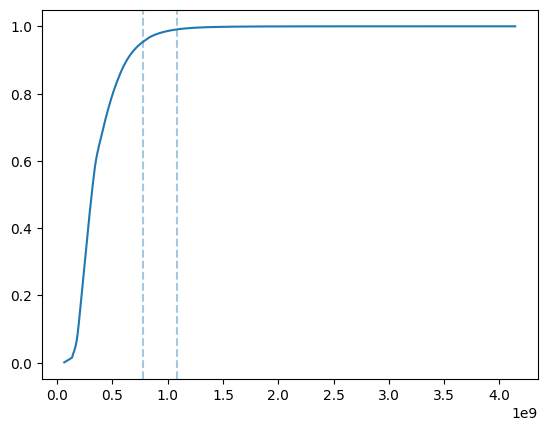

[0, 15, 24, 59, 321, 371, 449]


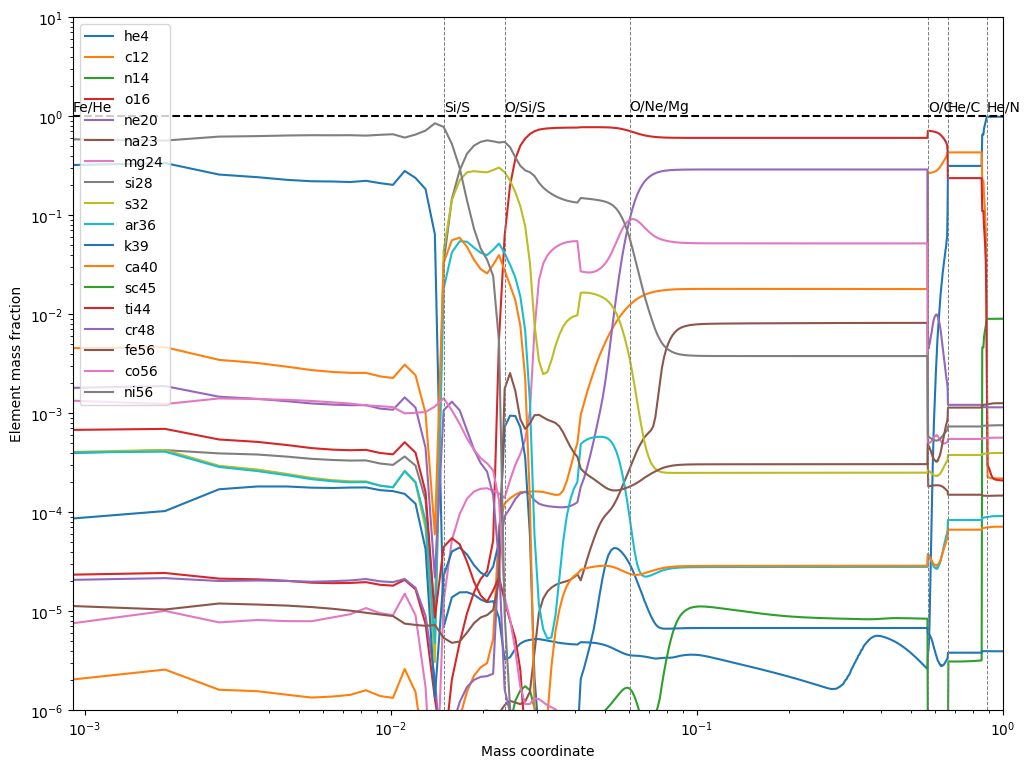

Before:  [[5.42e-02 3.36e-02 1.42e-01 1.98e+00 3.60e-01 8.70e-01 4.52e-01]
 [0.00e+00 1.34e+03 1.41e+03 1.73e+03 3.34e+03 3.86e+03 5.96e+03]
 [1.34e+03 1.41e+03 1.73e+03 3.34e+03 3.86e+03 5.96e+03 1.08e+04]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]]
filling factors [[8.30e-02 3.36e-02 1.42e-01 1.98e+00 3.60e-01 8.70e-01 4.52e-01]
 [0.00e+00 1.34e+03 1.41e+03 1.73e+03 3.34e+03 3.86e+03 5.96e+03]
 [1.34e+03 1.41e+03 1.73e+03 3.34e+03 3.86e+03 5.96e+03 1.08e+04]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.89e-14 5.91e-14 4.35e-14 4.52e-14 1.32e-14 4.14e-15 3.16e-16]
 [6.50e-01 2.13e-01 1.50e-06 2.03e-07 6.75e-08 6.87e-08 2.23e-08]
 [3.35e-02 3.31e-03 1.63e-05 2.24e-07 1.59e-08 5.27e-09 1.18e-09]
 [4.30e-04 2.91e-05 7.83e-07 5.15e-11 3.48e-12 3.92e-13 4.83e-14]
 [2.29e-01 1.25e-05 4.53e-06 3.35e-06 1.70e-02 3.77e-01 9.85e-01]
 [1.47e-06 9.90e-06 2.99e-03 1.78e-02 3.10e-01 3.91e-01 3.66e-04]
 [5.53e-07 1.43e-07 6.53e-06 2.44e-05 1.48e-05 8.5

In [31]:
#For each star, plot the build up
f_base = git_folder_loc + "NII_nebular_phase/data_creation/woosley_data/"
f_names = listdir(f_base)

he_masses_10, n_masses_10, o_masses_10 = [], [], []
he_masses_15, n_masses_15 = [], []

for k in range(len(f_names)):
    #Read in the actual Wooseley 2019, Ertl 2020 models
    if f_names[k] in requested_models:
        print()
        print()
        print('Creating expmodel for model: ', f_names[k])
        print()
        print()
    
        temp = open(f_base + f_names[k])

        header_array = hm.main(temp) #Get the header of the file
        cols_to_use = skip({10, 11}, len(header_array)-1)

        #Using the header, translate the element names to column numbers
        elements_to_use = [] 
        for i in range(len(element_names)):
            elements_to_use.append(name_to_number(element_names[i]))

        data = np.loadtxt(temp, skiprows = 6, usecols = cols_to_use)

        temp.close()
        
        Ekin_target = np.sum(E_kin(data[:, mass], data[:, velocity])) #The high resolution, true Ekin/Eexp
        
        #This section can be deleted later
        #============================================================================================
        if please_print == True:
            
            print("The true, initial kinetic energy is: ", '{0:.3g}'.format(Ekin_target))
            
            plt.plot(data[:, velocity], np.cumsum(data[:, mass])/np.cumsum(data[:, mass])[-1])
            plt.axvline(data[:, velocity][np.where(np.cumsum(data[:, mass]) > 0.99*np.cumsum(data[:, mass])[-1])[0][0]], linestyle = '--', alpha = 0.4)
            plt.axvline(data[:, velocity][np.where(np.cumsum(data[:, mass]) > 0.95*np.cumsum(data[:, mass])[-1])[0][0]], linestyle = '--', alpha = 0.4)
            plt.show()
        
        #============================================================================================

        #Determine the zone boundaries
        #============================================================================================
        fe_he = np.where( data[:, velocity]/(10**5) > vmin )[0][0] #Prevent any fallback material
        si_s = np.where( data[fe_he:, name_to_number('he4')] < 10**-2)[0][0] + fe_he
        o_si_s = np.where( data[si_s:, name_to_number('o16')] > 10**-2)[0][0] + si_s
        o_ne_mg = np.where( data[o_si_s:, name_to_number('ne20')] > data[o_si_s:, name_to_number('si28')])[0][0] + o_si_s
        o_c = np.where( data[o_ne_mg:, name_to_number('c12')] > data[o_ne_mg:, name_to_number('ne20')])[0][0] + o_ne_mg


        zones = [fe_he, si_s, o_si_s, o_ne_mg, o_c]

        #The Ic stars will not have outer he layers, the Ib will
        try:
            he_c = np.where( data[o_c:, name_to_number('he4')] > data[o_c:, name_to_number('o16')])[0][0] + o_c
            zones.append(he_c)

            try:
                he_n = np.where( data[he_c:, name_to_number('n14')] > data[he_c:, name_to_number('c12')])[0][0] + he_c
                zones.append(he_n)
                
            except:
                pass
        except:
            pass
        
        print(zones)

        #Cut off all layers with velocity greater than vmax
        outer_layer = np.where(np.cumsum(data[:, mass])/np.sum(data[:, mass]) > Mej_frac)[0][0]
        if outer_layer <= zones[-1]:
            pass
        else:
            zones.append(outer_layer)

        #Make a fancy figure
        #============================================================================================
        if please_plot == True:

            fig, ax = plt.subplots(1)
            transx = ax.get_xaxis_transform()

            cum_mass = np.cumsum(data[:outer_layer, mass])

            #Plot the mass fractions
            for i in range(len(elements_to_use)):

                element_mass_fraction = data[:outer_layer, elements_to_use[i]]

                ax.plot(cum_mass/cum_mass[-1], element_mass_fraction, label = element_names[i])

            #Plot the determined zone boundaries
            for j in range(len(zones)-1):
                ax.axvline(x = cum_mass[zones[j]]/cum_mass[-1], linestyle = '--', c = 'grey', lw = 0.7)

                fig.text(x = cum_mass[zones[j]]/cum_mass[-1],
                        y = 0.865, s = zone_names[j], transform = transx)

            ax.axhline(y = 1, linestyle = '--', c = 'black')

            ax.set_xlabel('Mass coordinate')
            ax.set_ylabel('Element mass fraction')

            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_xlim(cum_mass[0]/cum_mass[-1], 1)
            ax.set_ylim(10**-6, 10**1)

            ax.legend()

            fig.set_size_inches(12, 9)

            plt.savefig('M3p3_zones.png')
            plt.show()

        #Get the average mass fraction per zone for each element for each zone
        #============================================================================================

        #For the AJ15 mixing, if they are present, He/C and He/N are split into two zones each,
        #say He/C_core and He/C_env. The set up would then become e.g. 
        #Fe/He,Si/S,O/Si/S,O/Ne/Mg,O/C,He/C_core,He/N_core,He/C_env,He/N_env.
        #The core and env zones have the exact same composition, but the mass is divided 60/40. 
        #The velocity is taken to be the velocity at the mass coordinate we are currently on
        
        fracs_array = np.zeros((len(elements_to_use)+5+len(radioactive_names), len(zones)-1))

        #For the 5 core zones, everything is the same as in the non mixing case, so this remains unchanged
        #============================================================================================
        for i in range(len(zones)-1):
            l_bound, u_bound = zones[i], zones[i+1]

            #First assign the global variables
            zone_mass = np.cumsum(data[l_bound:u_bound, mass])[-1]/Msun    
            fracs_array[0, i] = zone_mass   
            fracs_array[1, i] = data[l_bound, velocity]/10**5 #From cm/s to km/s
            fracs_array[2, i] = data[u_bound, velocity]/10**5
            
            #The zone radius taken at 100d is the radius after 1 day (of which we have data)
            #plus the velocity times 99 days.
            zone_in_radius_100d = data[l_bound, radius] + fracs_array[1, i]*10**5 * 99 * 86400
            zone_out_radius_100d = data[u_bound, radius] + fracs_array[2, i]*10**5 * 99 * 86400
            zone_volume = (4/3)*np.pi* ( zone_out_radius_100d**3 - zone_in_radius_100d**3 )
            
            fracs_array[4, i] = zone_mass*Msun/zone_volume

            #Then the radioactive elements
            for m in range(len(radioactive_names)):
                
                isotopes = radioactive_groups[m]
                
                mass_frac = 0
                for q in range(len(isotopes)): #Sum over all isotopes
                    el_number = name_to_number(isotopes[q]) #Here we only want the exact isotopes as named in 'radioactive_groups'
                    mass_frac += (np.cumsum(data[l_bound:u_bound, mass]*data[l_bound:u_bound, el_number])[-1]/Msun)/zone_mass
                
                fracs_array[m+5, i] = mass_frac
            
            
            #And finally the remaining elements of interest
            for j in range(len(elements_to_use)):

                el = elements_to_use[j]
                isotopes = get_isotopes(el, exclude = radioactive_exclude)
                
                mass_frac = 0
                for q in range(len(isotopes)): #Sum over all isotopes
                    mass_frac += (np.cumsum(data[l_bound:u_bound, mass]*data[l_bound:u_bound, isotopes[q]])[-1]/Msun)/zone_mass
                row_index = j+5+len(radioactive_names) #j+5+... because of the global observables
                fracs_array[row_index, i] = mass_frac 

        fracs_array[1, 0] = 0.0 #Boundary condition of Vin being 0 at the core in SUMO
        
        
            
        if please_print == True:    
            print('Before: ', fracs_array[:4, :])
        
        #Restructure the array to have same 56Ni as Dessart:
        if do_dessart_ni == True:
            for p in range(len(dessart_names)):
                if dessart_names[p] in f_names[k]:
                    dessart_ni_index = p
            dessart_ni = dessart_ni_masses[dessart_ni_index]
            
            fracs_array = dessart_ni_scaler(fracs_array, dessart_ni)
        
        #Restructure the array to not have too big zones in vspace:
        fracs_array, n_necessary_subzones = restructure_nzones(fracs_array, data)
        
        #Add the filling factors:
        contrast_factors = [1, 10] + [contrast_factor]*(np.sum(fracs_array[3, :] == 0)-2)
        filling_factors = ff_determination(fracs_array[0, :], contrast_factors)
        fracs_array[3, :len(filling_factors)] = filling_factors
        
        if please_print == True: 
            print('After: ', fracs_array[:4, :])
            print('The filling factors are: ', fracs_array[3, :])
        
        #Finally, restructure the array to have reasonable Ekin:
        fracs_array = E_kin_restructure(fracs_array, Ekin_target)
        
        if please_print == True:
            print("The kinetic energy as perceived by SUMO is: ", '{0:.3g}'.format(E_kin_from_frac_array(fracs_array)))
            
        
        #Store the data and do other stuff
        #============================================================================================
        output_f_name = f_names[k] + '_expl_AJ_0_100_' + version_name + '.txt'
        
        if save == True:
            save_exp_model(fracs_array, n_necessary_subzones, output_f_name)
        

        if please_print == True:
            pass
            print(fracs_array[0, :])
            print(fracs_array[4, :])
            print()
            print("Si mass: ", np.sum(fracs_array[15, :]*fracs_array[0, :]))
            print("Ca mass: ", np.sum(fracs_array[19, :]*fracs_array[0, :]))
            print("Ni mass: ", np.sum(fracs_array[5, :]*fracs_array[0, :]))
            print("EJ mass: ", np.sum(fracs_array[0, :]))
            print(fracs_array[5:5+len(radioactive_names), :])
            print()
            print(fracs_array[5+len(radioactive_names):, :])
        
        #============================================================================================